<a href="https://colab.research.google.com/github/namoshi/colab/blob/master/PPCA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Probabilistic PCA using numpyro

In [1]:
!pip install numpyro

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 283 kB 29.8 MB/s 


In [2]:
!python mnist.py

Done
Done
Done
Done
Converting train-images-idx3-ubyte.gz to NumPy Array ...
Done
Converting train-labels-idx1-ubyte.gz to NumPy Array ...
Done
Converting t10k-images-idx3-ubyte.gz to NumPy Array ...
Done
Converting t10k-labels-idx1-ubyte.gz to NumPy Array ...
Done
Creating pickle file ...
Done!


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
 
import sys
#『ゼロから作るディープラーニング』のmnist.pyファイルが置いてあるドライブ上のパスを指定
sys.path.append('./')
from mnist import load_mnist
 
import jax
import jax.numpy as jnp
import numpyro
import numpyro.distributions as dist


In [4]:
train, test = load_mnist(normalize=False, flatten=False, one_hot_label=False)
 
data = np.squeeze(train[0][0:1000] / 256).copy()
segment = train[1][0:1000].copy()


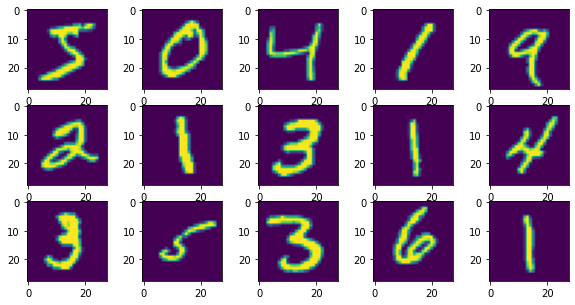

In [6]:
fig, axes = plt.subplots(3, 5, figsize=(10, 5))
 
for i, ax in enumerate(axes.flatten()):
    ax.imshow(data[i])
fig.show()

In [7]:
x = jnp.array(data.reshape(data.shape[0], -1))
 
# 潜在変数zの次元数
K = 10
# 元データの行数
N = x.shape[0]
# 元データの列数
D = x.shape[1]
 
print(f'nrow : {N}')
print(f'ncol : {D}')
print(f'dim of latent variable : {K}')
 
#nrow : 1000
#ncol : 784
#dim of latent variable : 10

nrow : 1000
ncol : 784
dim of latent variable : 10


In [8]:
def model(obs):
    # alpha : Wの各列の標準偏差
    alpha = numpyro.sample("alpha", dist.Exponential(rate=jnp.ones([K])).to_event(1))
    # W : ｚにかかる行列
    W = numpyro.sample("w", dist.Normal(jnp.zeros([K, D]), jnp.repeat(alpha, D, axis=0).reshape(K, D)).to_event(2))
    # xの標準偏差
    sigma = numpyro.sample("s", dist.HalfCauchy(scale=1))
    
    # 各データに対してzとxの分布を定義
    with numpyro.plate("plate", N):
        # z : 潜在変数
        z = numpyro.sample("z", dist.Normal(jnp.zeros([K]), jnp.ones([K])).to_event(1))
        # xの平均
        mean = jnp.matmul(z, W)
        # データxの分布
        x = numpyro.sample("x", dist.Normal(loc=mean, scale=sigma * jnp.ones([D])).to_event(1), obs=obs)

In [9]:
kernel = numpyro.infer.NUTS(model)
mcmc = numpyro.infer.MCMC(kernel, num_warmup=1000, num_samples=10000, thinning=5, num_chains=1)
 
mcmc.run(jax.random.PRNGKey(1), obs=x)

sample: 100%|██████████| 11000/11000 [08:33<00:00, 21.44it/s, 63 steps of size 5.76e-02. acc. prob=0.86]


In [10]:
samples = mcmc.get_samples()
samples.keys()
#dict_keys(['alpha', 's', 'w', 'z'])

dict_keys(['alpha', 's', 'w', 'z'])

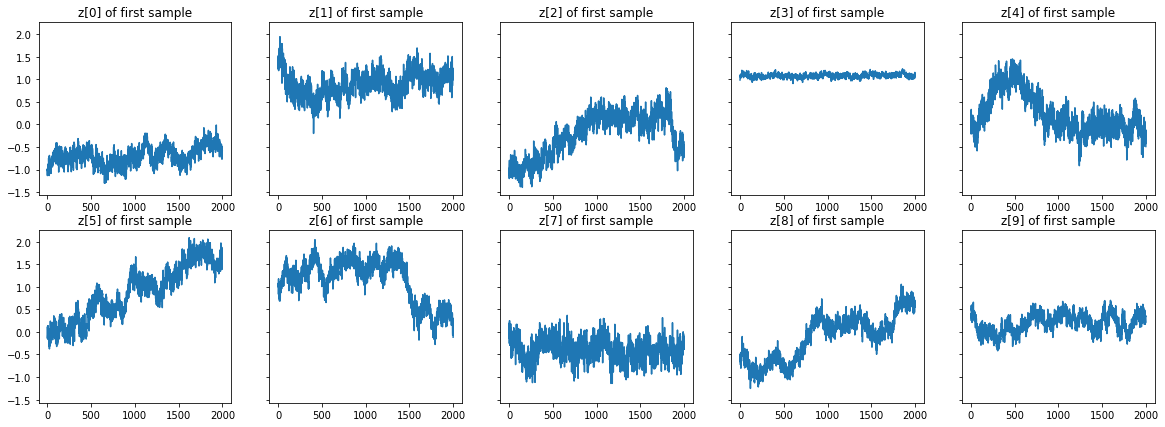

In [11]:
fig, axes = plt.subplots(2, 5, figsize=(20, 7), sharey=True)
axes = axes.flatten()
for k in range(K):
    axes[k].plot(samples["z"][:, 0, k])
    axes[k].set_title(f'z[{k}] of first sample')
fig.show()

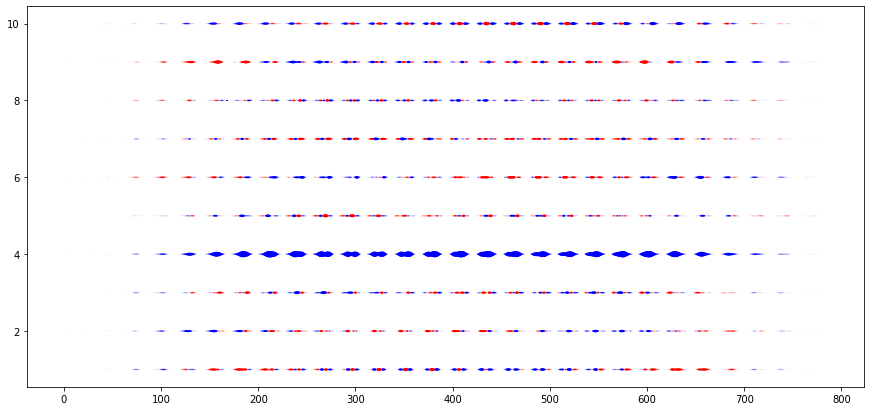

In [12]:
W_med = np.array(jnp.median(samples["w"], axis=0))
# 可視化のために、W_medを変形し7840×3の行列にする
xx, yy = np.meshgrid(np.arange(1, D+1), np.arange(1, K+1))
W_plt = np.c_[xx.flatten(), yy.flatten(), W_med.flatten()]
 
fig, ax = plt.subplots(figsize=(15, 7))
ax.scatter(W_plt[:, 0], W_plt[:, 1], s=100*(W_plt[:, 2]**2), c=["b" if x>=0 else "r" for x in W_plt[:, 2]])
fig.show()

In [13]:
z_med = np.array(jnp.median(samples["z"], axis=0))
 
list_z_med = list()
for i in range(K):
    df_z = pd.DataFrame(z_med[segment==i, :])
    df_z['segment'] = str(i)
    df_z = df_z.set_index('segment').stack().reset_index()
    df_z = df_z.rename(columns={'level_1': 'dim', 0: 'value'})
    list_z_med.append(df_z)
    del df_z
 
df_z_med = pd.concat(list_z_med, axis=0)


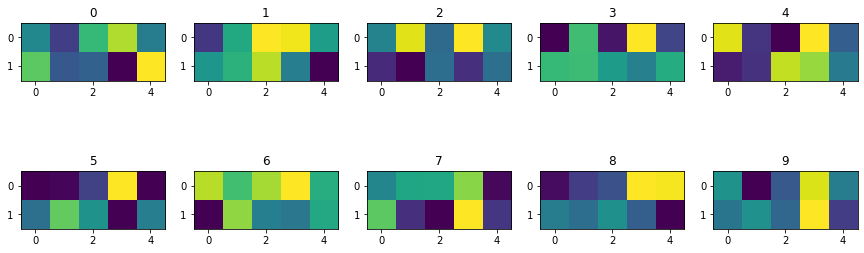

In [14]:
fig, axes = plt.subplots(2, 5, figsize=(15, 5))
axes = axes.flatten()
 
l_z_plt = list()
 
for s in range(10):
    z_plt = df_z_med[df_z_med['segment']==str(s)].groupby('dim', as_index=True)['value'].mean().values
    l_z_plt.append(z_plt)
 
    axes[s].imshow(z_plt.reshape(2, 5))
    axes[s].set_title(f'{s}')
    del z_plt
fig.show()

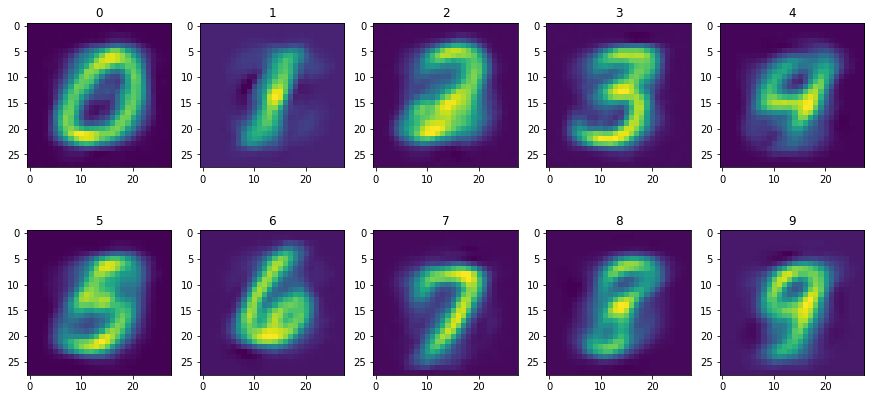

In [15]:
fig, axes = plt.subplots(2, 5, figsize=(15, 7))
axes = axes.flatten()
for s in range(10):
    axes[s].imshow(np.matmul(df_z_med[df_z_med['segment']==str(s)].groupby('dim', as_index=True)['value'].mean().values, W_med).reshape(28, 28))
    axes[s].set_title(str(s))
fig.show()